In [1]:
using Base, PyPlot, ProgressMeter, Statistics, _Data

┌ Warning: You are using a non-official build of Julia. This may cause issues with CUDA.jl.
│ Please consider using an official build from https://julialang.org/downloads/.
└ @ CUDA ~/.julia/packages/CUDA/75aiI/src/initialization.jl:180


In [2]:
function unpack!(img_u16:: AbstractMatrix{UInt16}, img_12p:: AbstractVector{UInt8})
    img_12p_reshaped = reshape(img_12p, 3, W ÷ 2, H)
    v0 = img_12p_reshaped[1, :, :]
    v1 = img_12p_reshaped[2, :, :]
    v2 = img_12p_reshaped[3, :, :]
    v1a = v1 .& 0x0F
    v1b = v1 .>> 4
    img_u16[1:2:end, :] .= (UInt16.(v0) .<< 4) .| v1a
    img_u16[2:2:end, :] .= (UInt16.(v2) .<< 4) .| v1b
    img_u16
end

unpack! (generic function with 1 method)

In [3]:
user = ENV["USER"]
dataset_list = readdir("/data/$user/data_raw")

64-element Vector{String}:
 "20240412_174445"
 "20240412_175734"
 "20240418_124413"
 "20240418_130220"
 "20240418_142709"
 "20240418_143358"
 "20240418_154850"
 "20240418_155346"
 "20240429_120319"
 "20240429_120825"
 "20240429_141416"
 "20240429_141625"
 "20240429_162159"
 ⋮
 "20240616_150356"
 "20240616_150953"
 "20240616_162251"
 "20240616_162537"
 "20240616_172857"
 "20240616_173537"
 "20240616_184421"
 "20240616_184920"
 "20240616_195256"
 "20240616_195703"
 "20240618_133719"
 "20240618_133822"

In [4]:
dataset = dataset_list[end]

file = open("/data/$user/data_raw/$(dataset)/ir.bin")

IOStream(<file /data/dogus/data_raw/20240618_133822/ir.bin>)

In [5]:
W, H = 5328, 4608
n_bytes = W * H * 3 ÷ 2
N = div(filesize(file), n_bytes)
img_12p = zeros(UInt8, n_bytes)
img = zeros(UInt16, W, H);

function read_raw!(img::AbstractMatrix{UInt16}, i::Integer)
    seek(file, (i - 1) * n_bytes)
    read!(file, img_12p)
    unpack!(img, img_12p)
end

read_raw! (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


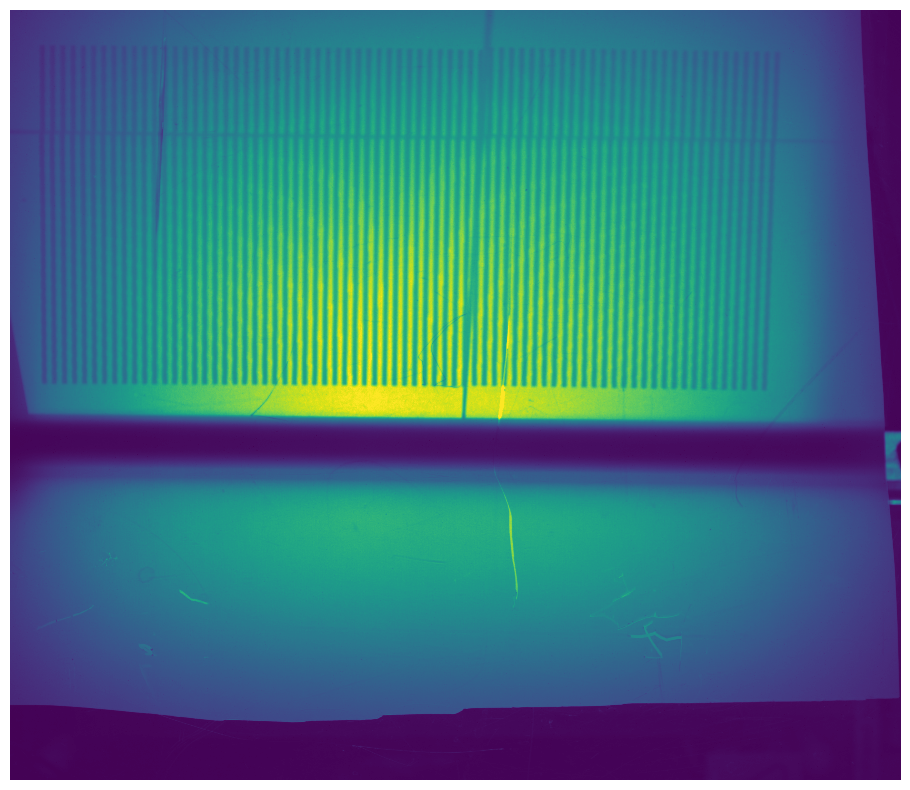

In [6]:
N2 = min(N, 10000)
step = round(Int, N2 / 40)
idx = 1:step:N2
images = zeros(Int16, W, H, length(idx))
@showprogress for (i, j) = enumerate(idx)
    read_raw!(img, j)
    images[:, :, i] = img
end
img_bg = dropdims(median(images; dims=3); dims=3);

figure(figsize=(15, 10))
imshow(img_bg'); axis("off")
display(gcf())
close("all")

In [7]:
ds_save = Dataset("$dataset")
w = Writer{W, H, 1}(ds_save, "img_bg"; raw=false)
write(w, round.(UInt16, img_bg))
close(w)

In [8]:
data_path(ds_save)

"/data/dogus/data/20240618_133822"

In [9]:
using HDF5

In [10]:
h5open(joinpath("../data/chuyu_pattern.h5"), "w") do file
    file["image"] = img_bg
end;